# Projection conflict risk

In [1]:
from copro import utils, pipeline, evaluation, plots

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sbs
import os, sys
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")

For better reproducibility, the version numbers of all key packages are provided.

In [2]:
utils.show_versions()

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]
copro version: 0.0.7b
geopandas version: 0.8.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
scikit-learn version: 0.23.2
matplotlib version: 3.2.1
seaborn version: 0.11.0
rasterstats version: 0.14.0


## Setting the scence

In the cfg-file, all the settings for the analysis are defined. By 'parsing' (i.e. reading) it, all settings and file paths are known to the model. This is a simple way to make the code independent of the input data and settings.

**Note** that the cfg-file can be stored anywhere, not per se in the same directory where the model data is stored (as in this example case). Make sure that the paths in the cfg-file are updated if you use relative paths and change the folder location of th cfg-file.

**Note** too, that only a few settings of the cfg-file are needed for making projections. For convenience, though, the same file structure can be used and CoPro picks the settings needed.

In [3]:
settings_file = 'example_settings_proj.cfg'

Based on this cfg-file, the set-up of the run can be initialized. One part of the cfg-file is the specification and creation of an output folder.

In [4]:
config, out_dir = utils.initiate_setup(settings_file)


#### CoPro version 0.0.7b ####
#### For information about the model, please visit https://copro.readthedocs.io/ ####
#### Copyright (2020-2020): Jannis M. Hoch, Sophie de Bruin, Niko Wanders ####
#### Contact via: j.m.hoch@uu.nl ####
#### The model can be used and shared under the MIT license ####

INFO: verbose mode on: False
INFO: saving output to folder C:\Users\hoch0001\Documents\_code\copro\example\OUT_PROJ
INFO: no conflict file was specified, hence downloading data from http://ucdp.uu.se/downloads/ged/ged201-csv.zip to C:\Users\hoch0001\Documents\_code\copro\example\example_data\UCDP\ged201-csv.zip


We also need to load in the selected polygons from the very first notebook.

In [5]:
selected_polygons_gdf = gpd.read_file('polygons.shp')

Again, for the conversion from numpy array to dataframe this requires a few more steps.

In [6]:
global_arr = np.load('global_df.npy', allow_pickle=True)
global_df = pd.DataFrame(data=global_arr, columns=['geometry', 'ID'])
global_df.set_index(global_df.ID, inplace=True)
global_df.drop(['ID'] , axis=1, inplace=True)

## Read data from files

Similar as in the second notebook, we need to collect the variable values for the projection time period. This time, however, we do not need to check whether conflict took place in a polygon as we are now in the projection mode and will not train and test the model again.

**Note** that for this projection, we simply used the same input data as for the reference data. This way we avoided putting more and more files in the repo. Of course, if one were to make an 'actual' projection, the simulation period would lie in the future.

In [7]:
X = pipeline.create_X(config, selected_polygons_gdf)

INFO: reading data for period from 2010 to 2015
INFO: entering year 2010
INFO: entering year 2011
INFO: entering year 2012
INFO: entering year 2013
INFO: entering year 2014
INFO: entering year 2015
INFO: all data read
INFO: saving X data by default to file C:\Users\hoch0001\Documents\_code\copro\example\OUT_PROJ\X.npy


As you can see, the stored file is name ``X.npy``. This is because for the projections, we naturally would not have observations of conflict for the future.

## Project!

Before we can make a projection, we need to first get the scaler for the variables. **Note** that the classifier ``clf`` will be loaded from a pickled-object (see notebook nb03) in the ``pipeline.run_prediction()`` function.

In [9]:
scaler, clf = pipeline.prepare_ML(config)

With this all in place, we can use the data, the scaler, and the trained classifier to make a prediction whether conflict will take place in a polygon or not. This step still includes multiple predictions per polygon.

In [11]:
y_df = pipeline.run_prediction(X, scaler, config)

INFO: scaling the data from projection period
INFO: loading classifier from C:\Users\hoch0001\Documents\_code\copro\example\OUT\clf.pkl
INFO: making the projection


All the fancy evaluation metrics are not applicable anymore, as we don't have observed data for the future projections. We can still look which fraction of predictions actually predicted conflict for a given polygon.

In [12]:
df_hit, gdf_hit = evaluation.polygon_model_accuracy(y_df, global_df, out_dir=None, make_proj=True)

And this is how it looks like:

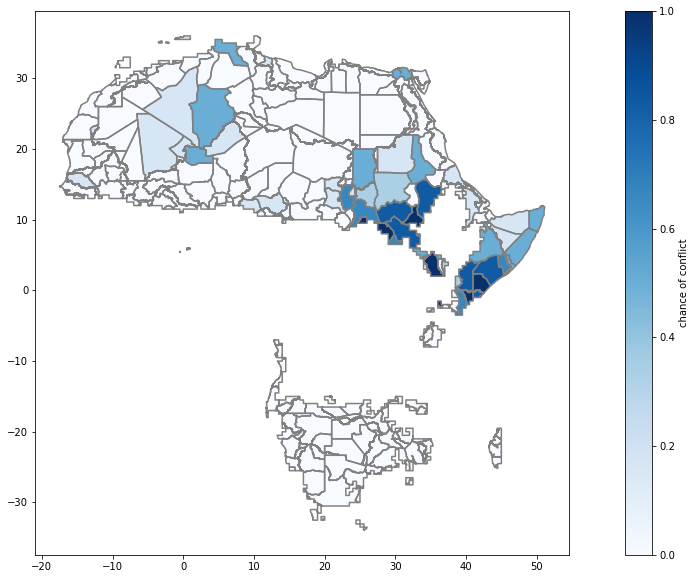

In [14]:
ax = gdf_hit.plot(column='fraction_correct_conflict_predictions', legend=True, figsize=(20, 10), cmap='Blues', vmin=0, vmax=1,
             legend_kwds={'label': "chance of conflict", 'orientation': "vertical"})
selected_polygons_gdf.boundary.plot(ax=ax, color='0.5');

**Note** that this plot may be different than a similar plot in the previous notebook. This is not unlikely as we use a different amount and different predictions in general here! For instance, we did not repeat the predictions multiple times, nor did we split the data points in training data and test data. Nevertheless, the pattern of projected conflict risk looks very sensible given the outcome of the reference plots.